### load modules

In [1]:
%matplotlib inline
import numpy as np
import os, glob
import matplotlib.pyplot as plt
import xarray
import pandas as pd
from matplotlib.dates import DateFormatter

In [2]:
plt.rc('font',size=16)

### define paths

In [3]:
dataPath = '/glade2/scratch2/domingom/Cheyenne/XPIA_mesoLES/SIMULS/'
outPath  = '/glade/scratch/doubrawa/postProcessing/'

In [4]:
dataPaths = {
    'LES_25'  :'/glade/scratch/doubrawa/postProcessing',
    'LES_100' :'/glade/scratch/doubrawa/postProcessing',
    'LES_333' :'/glade/scratch/doubrawa/VLES',
    'SH_333'  :'/glade/scratch/doubrawa/SH',
    'MYNN_333':'/glade/scratch/doubrawa/MYNN'}

define some parameters

In [5]:
lat          = 40.050028
lon          = -105.003835
procId       = {3:1021,4:1180}
variables    = ['U','V','W','T','PH','PHB','HGT','RMOL']

allocate space for data

In [6]:
data = {}

read in domingo's data

In [7]:
def read_wrfout_variable(day,hour,half_hour_idx,domainId,patch,varName):    
    wrfoutPath = glob.glob(os.path.join(dataPath,
                       'WRF_mesoLES_4dom_RAP_2015_03_{0}_mesoLES'.format(day),
                       'HOUR_{0}_{1}'.format(hour,half_hour_idx),
                        'wrfout_d0{0}_2015-03-*_{1:04d}'.format(domainId,patch)))[0]    
    ncfile = xarray.open_dataset(wrfoutPath)
    data   = ncfile[varName]    
    return data

In [65]:
data = {prefix:{} for prefix in dataPaths.keys()}

In [104]:
day           = 27

for ivar,varName in enumerate(['W']):#'T','PH','PHB'

    print "**********************"
    print "{0:22s}".format(varName)
    
    for domainId in [3]:
        
        print "domain {0}".format(domainId)

        prefix       = 'LES_25' if domainId==4 else 'LES_100'
        firstTime    = 1             

        for hour in range(14,24):
            
            print "hour {0:02d}".format(hour)

            for half_hour_idx in [1,2]:

                #
                # Read in necessary patches and glue them
                #  
                if domainId==3:
                    datavar = read_wrfout_variable(day,hour,half_hour_idx,domainId,1021,varName)                        
                else:    
                    for ipatch,patch in enumerate([1180,1220]):                
                        datatmp = read_wrfout_variable(day,hour,half_hour_idx,domainId,patch,varName)                                                       
                        if ipatch==0:
                            datavar = datatmp
                        else:                            
                            dimName = [ x for x in datatmp.dims if 'south_north' in x ]                            
                            datavar = xarray.concat([datavar,datatmp],dim=dimName[0])

                #
                # find closest j,i to lat,lon
                #                   
                j = np.argmin(np.abs(datavar.XLAT.data[0,:,0]-lat))
                i = np.argmin(np.abs(datavar.XLONG.data[0,0,:]-lon))

                #
                # grab a ~ 300 m x 300 m box around j,i
                #
                npts = 1 if domainId==3 else 6
                datavar = datavar[:,:,j-npts:j+npts+1,i-npts:i+npts+1]

                #
                # get spatial average
                #
                datavar = datavar.mean(axis=2)
                datavar = datavar.mean(axis=2)            

                if firstTime:
                    data[prefix][varName] = datavar
                    firstTime = 0
                else:
                    data[prefix][varName] = xarray.concat([data[prefix][varName],datavar],dim='Time')

**********************
W                     
domain 3
hour 14
hour 15
hour 16
hour 17
hour 18
hour 19
hour 20
hour 21
hour 22
hour 23


also grab terrain height at the desired point

In [72]:
hgt = read_wrfout_variable(day,hour,half_hour_idx,domainId,procId[domainId],'HGT')    
j   = np.argmin(np.abs(hgt.XLAT.data[0,:,0]-lat))
i   = np.argmin(np.abs(hgt.XLONG.data[0,0,:]-lon))
hgt = hgt[1,j,i]

check that it looks decent

In [104]:
#
# based on min/max height, make a regular vector of heights for the mesh
#
zmin, zmax = np.min(timerecord[prefix]['z']), np.max(timerecord[prefix]['z'])
z1d        = np.arange(zmin, zmax, 5.0)
nz         = len(z1d)

   

In [105]:
#
# also get time information and make a regular vector of times for the mesh
#
nt, nz    = timerecord[prefix]['z'].shape
t1d       = range(nt)
t1d_smart = timerecord[prefix]['PH']['XTIME'].values

In [107]:
#
# make the mesh
#
[zMesh,tMesh] = np.meshgrid(z1d,t1d_smart)

In [111]:
#
# allocate space to hold values of theta, then fill it up
#
nt,nz = zMesh.shape
array = np.zeros((nt,nz))
for it in range(nt):    
    xo = zMesh[0,:]
    xi = timerecord[prefix]['z'].data[it,1:]
    yi = timerecord[prefix]['T'].data[it,:]
    array[it,:] = np.interp(xo,xi,yi)

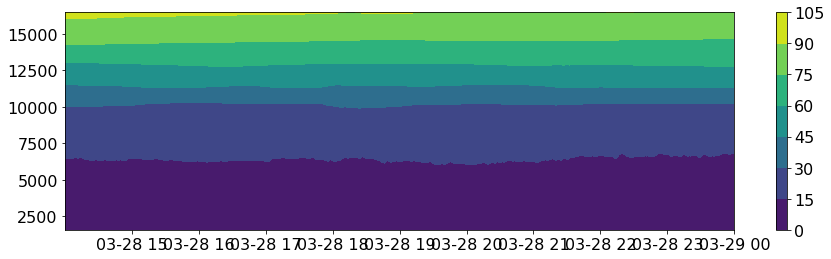

In [114]:
plt.figure(figsize=(15,4))
p   = plt.contourf(tMesh,zMesh,array)
plt.colorbar(p)
# plt.ylim([0,3000])

read in my data

In [73]:
variables    = ['U','V','W','T','PH','PHB','HGT','RMOL','PBLH']

In [74]:
day           = 27

for simKey in ['LES_333','SH_333','MYNN_333']:
    
    firstTime     = 1             
    wrfoutPaths   = sorted(glob.glob(os.path.join(dataPaths[simKey],'03{0}15'.format(day+1),'wrfout_d03*'.format(domainId))))

    for wrfoutPath in wrfoutPaths:
        print os.path.split(wrfoutPath)[-1]

        #
        # Read in the (meta)data
        #
        ncfile = xarray.open_dataset(wrfoutPath)

        #
        # Define some coordinates for the xarrays
        #
        ncfile['west_east'] = ncfile.west_east
        ncfile['west_east_stag'] = ncfile.west_east_stag

        ncfile['south_north'] = ncfile.south_north        
        ncfile['south_north_stag'] = ncfile.south_north_stag

        ncfile['bottom_top'] = ncfile.bottom_top
        ncfile['bottom_top_stag'] = ncfile.bottom_top_stag


        j = np.argmin(np.abs(ncfile.XLAT.data[0,:,0]-lat))
        i = np.argmin(np.abs(ncfile.XLONG.data[0,0,:]-lon))

        varNow = ncfile[variables].isel(west_east=i, west_east_stag=i,
                                        south_north=j, south_north_stag=j,
                                        bottom_top=range(60), bottom_top_stag=range(60))
        
        if 'T' in variables:
            # I got this + 300 K from share/wrf_timeseries.F
            varNow['T'].data = varNow['T'].data + 300.0

        if firstTime:
            data[simKey] = varNow
            firstTime = 0
        else:
            data[simKey] = xarray.concat([data[simKey],varNow],dim='Time')

wrfout_d03_2015-03-28_12:30:00
wrfout_d03_2015-03-28_13:00:00
wrfout_d03_2015-03-28_13:30:00
wrfout_d03_2015-03-28_14:00:00
wrfout_d03_2015-03-28_14:30:00
wrfout_d03_2015-03-28_15:00:00
wrfout_d03_2015-03-28_15:30:00
wrfout_d03_2015-03-28_16:00:00
wrfout_d03_2015-03-28_16:30:00
wrfout_d03_2015-03-28_17:00:00
wrfout_d03_2015-03-28_17:30:00
wrfout_d03_2015-03-28_18:00:00
wrfout_d03_2015-03-28_18:30:00
wrfout_d03_2015-03-28_19:00:00
wrfout_d03_2015-03-28_19:30:00
wrfout_d03_2015-03-28_20:00:00
wrfout_d03_2015-03-28_20:30:00
wrfout_d03_2015-03-28_21:00:00
wrfout_d03_2015-03-28_21:30:00
wrfout_d03_2015-03-28_22:00:00
wrfout_d03_2015-03-28_22:30:00
wrfout_d03_2015-03-28_23:00:00
wrfout_d03_2015-03-28_23:30:00
wrfout_d03_2015-03-29_00:00:00
wrfout_d03_2015-03-28_12:30:00
wrfout_d03_2015-03-28_13:00:00
wrfout_d03_2015-03-28_13:30:00
wrfout_d03_2015-03-28_14:00:00
wrfout_d03_2015-03-28_14:30:00
wrfout_d03_2015-03-28_15:00:00
wrfout_d03_2015-03-28_15:30:00
wrfout_d03_2015-03-28_16:00:00
wrfout_d

compute z and make a mesh of z vs time

In [102]:
zMesh = {} ; tMesh = {}

for ikey,key in enumerate(data.keys()):
    
    print key
    
    #
    # calculate actual height above ground
    #
    data[key]['z'] = (data[key]['PH'] + data[key]['PHB'])/9.81 - hgt

    #
    # based on min/max height, make a regular vector of heights for the mesh
    #
    zmin, zmax = np.min(data[key]['z']), np.max(data[key]['z'])
    z1d        = np.arange(zmin, zmax, 10.0)
    nz         = len(z1d)

    #
    # also get time information and make a regular vector of times for the mesh
    #
    nt, nz    = data[key]['z'].shape
    t1d       = range(nt)
    t1d_smart = data[key]['PH']['XTIME'].values

    #
    # make the mesh
    #
    [zMesh[key],tMesh[key]] = np.meshgrid(z1d,t1d_smart)

MYNN_333
LES_100
LES_333
LES_25
SH_333


compute wind speed 

# unstagger this later...

In [140]:
for ikey,key in enumerate(data.keys()):
    
    print key
    
    #
    # calculate actual height above ground
    #
    data[key]['WS'] = np.sqrt(data[key]['U']**2+data[key]['V']**2)

SH_333
LES_100
MYNN_333
LES_25
LES_333


visualize

In [88]:
levels = {'T':np.arange(300,320,0.5),
          'WS':np.arange(0,20,1),
           'W':np.arange(-5,5,0.1)}

cmaps = {'T':'RdBu_r',
         'WS':'YlGnBu',
         'W':'seismic'}

In [91]:
    nt,nz = zMesh[key].shape

In [92]:
nt

3600

In [93]:
nz

2982

In [94]:
xo = zMesh[key][0,:]
print xo.shape

(2982,)


In [95]:
xi = data[key]['z'].data[it,:]
print xi.shape

(73,)


In [96]:
yi = data[key][varContour].data[it,:]
print yi.shape        

(72,)


LES_25
LES_100


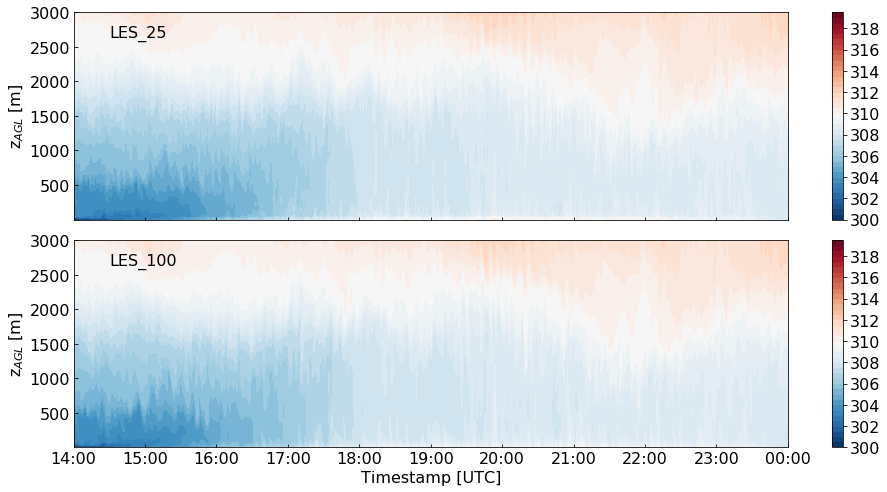

In [103]:
varContour = 'T'
tStartUTC  = np.datetime64('2015-03-28 14:00')
tEndUTC    = np.datetime64('2015-03-29 00:00')
zMax       = 3000

keys = ['LES_25','LES_100']#,'LES_333','SH_333','MYNN_333']

fig = plt.figure(figsize=(16,4*len(keys)))
ax  = {}

for iax,key in enumerate(keys):
    
    print key
    
    if iax==0:
        ax[iax] = fig.add_subplot(len(keys),1,iax+1)
    else:
        ax[iax] = fig.add_subplot(len(keys),1,iax+1,sharex=ax[0],sharey=ax[0])

    #
    # allocate space to hold values of theta, then fill it up
    #
    nt,nz = zMesh[key].shape
    array = np.zeros((nt,nz))
    for it in range(nt):    
        xo = zMesh[key][0,:]
        xi = data[key]['z'].data[it,:][1:]
        yi = data[key][varContour].data[it,:]+300
        array[it,:] = np.interp(xo,xi,yi)

    #
    # contour plot
    #
    p   = ax[iax].contourf(tMesh[key],zMesh[key],array,levels=levels[varContour],cmap=cmaps[varContour])
    plt.colorbar(p)

    ax[iax].set_ylim([0,zMax])
    ax[iax].set_xlim([tStartUTC,tEndUTC])

    ax[iax].set_ylabel('z$_{{AGL}}$ [m]')
    ax[iax].xaxis.set_major_formatter(DateFormatter('%H:%M'))
    
    ax[iax].tick_params(which='both',direction='in')    
    if iax<(len(keys)-1):
        plt.setp(ax[iax].get_xticklabels(), visible=False)
        
    ax[iax].text(0.05,0.9,key,verticalalignment='center', transform=ax[iax].transAxes)
    
    #
    # 
    #
    if 'LES' not in key:
        if 'PBLH' in data[key].keys():
            xaxis = data[key]['PBLH']['XTIME'].values
            yaxis = data[key]['PBLH'].data
            ax[iax].plot(xaxis,yaxis,'o',mfc='None',mec='k')
        
yticks = ax[iax].get_yticks()[1:]
ax[iax].set_yticks(yticks)
ax[iax].set_xlabel('Timestamp [UTC]')
fig.subplots_adjust(hspace=0.1)

In [99]:
# varContour = 'W'
# tStartUTC  = np.datetime64('2015-03-28 14:00')
# tEndUTC    = np.datetime64('2015-03-29 00:00')
# zMax       = 3000

# keys = ['LES_25','LES_100','LES_333','SH_333','MYNN_333']

# fig = plt.figure(figsize=(16,4*len(keys)))
# ax  = {}

# for iax,key in enumerate(keys):
    
#     if iax==0:
#         ax[iax] = fig.add_subplot(len(keys),1,iax+1)
#     else:
#         ax[iax] = fig.add_subplot(len(keys),1,iax+1,sharex=ax[0],sharey=ax[0])

#     #
#     # allocate space to hold values of theta, then fill it up
#     #
#     nt,nz = zMesh[key].shape
#     array = np.zeros((nt,nz))
#     for it in range(nt):    
#         xo = zMesh[key][0,:]
#         xi = data[key]['z'].data[it,:]
#         yi = data[key][varContour].data[it,:]
#         array[it,:] = np.interp(xo,xi,yi)

#     #
#     # contour plot
#     #
#     p   = ax[iax].contourf(tMesh[key],zMesh[key],array,levels=levels[varContour],cmap=cmaps[varContour])
#     plt.colorbar(p)

#     ax[iax].set_ylim([0,zMax])
#     ax[iax].set_xlim([tStartUTC,tEndUTC])

#     ax[iax].set_ylabel('z$_{{AGL}}$ [m]')
#     ax[iax].xaxis.set_major_formatter(DateFormatter('%H:%M'))
    
#     ax[iax].tick_params(which='both',direction='in')    
#     if iax<(len(keys)-1):
#         plt.setp(ax[iax].get_xticklabels(), visible=False)
        
#     ax[iax].text(0.05,0.9,key,verticalalignment='center', transform=ax[iax].transAxes)
    
#     #
#     # 
#     #
#     if 'LES' not in key:
#         if 'PBLH' in data[key].keys():
#             xaxis = data[key]['PBLH']['XTIME'].values
#             yaxis = data[key]['PBLH'].data
#             ax[iax].plot(xaxis,yaxis,'o',mfc='None',mec='k')
        
# yticks = ax[iax].get_yticks()[1:]
# ax[iax].set_yticks(yticks)
# ax[iax].set_xlabel('Timestamp [UTC]')
# fig.subplots_adjust(hspace=0.1)